### Imports and reading data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#Import scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#Import pipeline
from sklearn.pipeline import Pipeline

from sklearn.neural_network import MLPRegressor

In [2]:
data = pd.read_csv('train.csv')

In [3]:
# Tasks to do:
enable_grid_search = False
make_prediction = True
create_result_graph = True
try_out_tensorflow = True

### Data exploration

In [4]:
# Loop through the data indeces
def extend_snow(data):
    data['snow'] = data['snow'].fillna(0)
    snow = 0
    replaceCounter = 0
    for i in range(len(data)):
        # If snowfall is not 0, save the value
        if data['snow'][i] != 0:
            snow = data['snow'][i]
            # Replace the following 24 hours with the saved value
            replaceCounter = 23
        elif (replaceCounter > 0):
            data['snow'][i] = snow
            replaceCounter -= 1
    return data
    
def avg_temp_of_day(data):
    temp = 0
    temp_count = 0
    for i in range(len(data)):
        temp += data['temp'][i]
        temp_count += 1
        if ((i + 1) % 24 == 0):
            for j in range(24):
                data['avg_temp_of_day'][i-j] = temp / temp_count
            temp = 0
            temp_count = 0
    return data


def isDayLight(data):
    f = open('daylight_new.txt', 'r')
    line = f.readline()
    for i in range(len(data)):
        line_info = line.split(",")
        line_date = line_info[0]
        # If date is the same
        if data['date'][i] == line_date:
            data_tund = int(data['hour'][i])
            if data_tund >= int(line_info[1]) and data_tund <= int(line_info[2]):
                data['valge'][i] = 1
        else:
            line = f.readline()

    f.close()
    return data

### Data Preprocessing

In [5]:
def preprocess_data(data):

    # Time [time]
    # Splitting time into month, day, hour columns
    data['month'] = data['time'].apply(lambda x: int(x.split('-')[1]))
    data['day'] = data['time'].apply(
        lambda x: int(x.split('-')[2].split(' ')[0]))
    data['hour'] = data['time'].apply(
        lambda x: int(x.split(' ')[1].split(':')[0]))


    # Creating a new column for day of the week (0 = Monday, 6 = Sunday)
    data['date'] = data['time'].apply(lambda x: x.split(' ')[0])
    data['day_of_week'] = pd.to_datetime(data['date']).dt.dayofweek
    # Turning day of the week into a cyclic feature
    data['day_of_week_sin'] = np.sin(data['day_of_week'] * (2 * np.pi / 7))
    data['day_of_week_cos'] = np.cos(data['day_of_week'] * (2 * np.pi / 7))
    # Creating weekend column
    data['weekend'] = data['day_of_week'].apply(lambda x: 1 if x > 4 else 0)

    data = data.drop(['day_of_week'], axis=1)
    
    #Is the sun up (did not improve the model)
    #data['valge'] = 0
    #data = isDayLight(data)


    # Transform day of the month into a cyclic feature
    data['day_sin'] = np.sin(2 * np.pi * data['day']/31)
    data['day_cos'] = np.cos(2 * np.pi * data['day']/31)
    data = data.drop(['day'], axis=1)

    # Dropping and date column
    data = data.drop(['date'], axis=1)
    

    # Turning hour into a cyclic feature
    data['hour_sin'] = data['hour'].apply(
        lambda x: np.sin(x * (2 * np.pi / 24)))
    data['hour_cos'] = data['hour'].apply(
        lambda x: np.cos(x * (2 * np.pi / 24)))
    data = data.drop(['hour'], axis=1)


    # Tranforming month column
    data['month_sin'] = data['month'].apply(
        lambda x: np.sin(x * (2 * np.pi / 12)))
    data['month_cos'] = data['month'].apply(
        lambda x: np.cos(x * (2 * np.pi / 12)))
    data = data.drop(['month'], axis=1)

    data = data.drop(['time'], axis=1)
    # Temp [temp]

    # Dew Point [dwpt]

    # Humidity [rhum]

    # Hourly Precipitation [prcp]
    #DROP PRCP
    data = data.drop(['prcp'], axis=1)

    # Snow depth [snow]

    data = extend_snow(data)

    # Wind direction [wdir]
    # Transforming wind direction into sin and cos

    data['wdir_sin'] = data['wdir'].apply(
        lambda x: np.sin(x * (2 * np.pi / 360)))
    data['wdir_cos'] = data['wdir'].apply(
        lambda x: np.cos(x * (2 * np.pi / 360)))
    # Dropping wind direction column
    data = data.drop(['wdir'], axis=1)

    # Wind speed [wspd]

    # Peak wind gust [wpgt]

    # Pressure [pres]
    data['pres'] = data['pres'].apply(lambda x: x-1000)

    # Fill NaN values with previous value
    data['coco'] = data['coco'].fillna(method='ffill')
    # Transform condition code into one-hot vectors
    data = pd.get_dummies(data, columns = ["coco"])

    # electricity price [el_price]


    # Create feature for the avg temp of the day
    data['avg_temp_of_day'] = 0
    data = avg_temp_of_day(data)
    
    data = data.fillna(0)

    return data

data = preprocess_data(data)
pd.options.display.max_columns = None
data.head()

C:\Users\tktaa\AppData\Local\Temp\ipykernel_61340\853852080.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['snow'][i] = snow
C:\Users\tktaa\AppData\Local\Temp\ipykernel_61340\853852080.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['avg_temp_of_day'][i-j] = temp / temp_count


,temp,dwpt,rhum,snow,wspd,wpgt,pres,el_price,consumption,day_of_week_sin,day_of_week_cos,weekend,day_sin,day_cos,hour_sin,hour_cos,month_sin,month_cos,wdir_sin,wdir_cos,coco_1.0,coco_2.0,coco_3.0,coco_4.0,coco_5.0,coco_6.0,coco_7.0,coco_8.0,coco_9.0,coco_10.0,coco_12.0,coco_13.0,coco_14.0,coco_15.0,coco_16.0,coco_17.0,coco_18.0,coco_19.0,coco_20.0,coco_21.0,coco_22.0,coco_23.0,coco_25.0,avg_temp_of_day
0,11.2,10.3,94.0,0.0,7.2,16.7,12.6,0.09016,0.577,0.974928,-0.222521,0,0.201299,0.97953,0.000000,1.000000,-1.0,-1.836970e-16,-0.642788,0.766044,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6
1,10.7,9.6,93.0,0.0,7.2,13.0,12.6,0.09251,0.594,0.974928,-0.222521,0,0.201299,0.97953,0.258819,0.965926,-1.0,-1.836970e-16,-0.642788,0.766044,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6
2,9.9,9.0,94.0,0.0,7.2,13.0,12.2,0.08890,0.685,0.974928,-0.222521,0,0.201299,0.97953,0.500000,0.866025,-1.0,-1.836970e-16,-0.642788,0.766044,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6
3,10.0,8.4,90.0,0.0,7.2,13.0,11.9,0.08735,1.016,0.974928,-0.222521,0,0.201299,0.97953,0.707107,0.707107,-1.0,-1.836970e-16,-0.500000,0.866025,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6
4,9.0,8.1,94.0,0.0,3.6,13.0,11.4,0.08688,0.677,0.974928,-0.222521,0,0.201299,0.97953,0.866025,0.500000,-1.0,-1.836970e-16,-0.866025,0.500000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6


In [6]:
#normalize values

minmaxerRhum = MinMaxScaler()
data["rhum"] = minmaxerRhum.fit_transform(data[['rhum']])

minmaxerTemp = MinMaxScaler()
data["temp"] = minmaxerTemp.fit_transform(data[['temp']])

minmaxerDwpt = MinMaxScaler()
data["dwpt"] = minmaxerDwpt.fit_transform(data[['dwpt']])

minmaxerWspd = MinMaxScaler()
data["wspd"] = minmaxerWspd.fit_transform(data[['wspd']])

minmaxerWpgt = MinMaxScaler()
data["wpgt"] = minmaxerWpgt.fit_transform(data[['wpgt']])

minmaxerPres = MinMaxScaler()
data["pres"] = minmaxerPres.fit_transform(data[['pres']])

minmaxerSnow = MinMaxScaler()
data["snow"] = minmaxerSnow.fit_transform(data[['snow']])

minmaxerPrice = MinMaxScaler()
data["el_price"] = minmaxerPrice.fit_transform(data[['el_price']])

#Does not help
#minmaxerAvgTemp = MinMaxScaler()
#data["avg_temp_of_day"] = minmaxerAvgTemp.fit_transform(data[['avg_temp_of_day']])

data.head()


,temp,dwpt,rhum,snow,wspd,wpgt,pres,el_price,consumption,day_of_week_sin,day_of_week_cos,weekend,day_sin,day_cos,hour_sin,hour_cos,month_sin,month_cos,wdir_sin,wdir_cos,coco_1.0,coco_2.0,coco_3.0,coco_4.0,coco_5.0,coco_6.0,coco_7.0,coco_8.0,coco_9.0,coco_10.0,coco_12.0,coco_13.0,coco_14.0,coco_15.0,coco_16.0,coco_17.0,coco_18.0,coco_19.0,coco_20.0,coco_21.0,coco_22.0,coco_23.0,coco_25.0,avg_temp_of_day
0,0.648696,0.786290,0.9250,0.0,0.227129,0.229617,0.588928,0.022523,0.577,0.974928,-0.222521,0,0.201299,0.97953,0.000000,1.000000,-1.0,-1.836970e-16,-0.642788,0.766044,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6
1,0.640000,0.772177,0.9125,0.0,0.227129,0.168053,0.588928,0.023110,0.594,0.974928,-0.222521,0,0.201299,0.97953,0.258819,0.965926,-1.0,-1.836970e-16,-0.642788,0.766044,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6
2,0.626087,0.760081,0.9250,0.0,0.227129,0.168053,0.584217,0.022208,0.685,0.974928,-0.222521,0,0.201299,0.97953,0.500000,0.866025,-1.0,-1.836970e-16,-0.642788,0.766044,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6
3,0.627826,0.747984,0.8750,0.0,0.227129,0.168053,0.580683,0.021820,1.016,0.974928,-0.222521,0,0.201299,0.97953,0.707107,0.707107,-1.0,-1.836970e-16,-0.500000,0.866025,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6
4,0.610435,0.741935,0.9250,0.0,0.113565,0.168053,0.574794,0.021703,0.677,0.974928,-0.222521,0,0.201299,0.97953,0.866025,0.500000,-1.0,-1.836970e-16,-0.866025,0.500000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.6


### Training and validation

In [7]:
X = data.drop(['consumption'], axis=1)
y = data['consumption']
#train_test_split for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5 )
print(X_train.shape, y_train.shape)

(6014, 43) (6014,)


In [8]:
if(enable_grid_search): # Enable to run grid search
    kf = KFold(n_splits=10,shuffle=True ,random_state=1)
    rf = RandomForestRegressor(random_state=1)
    gbr = GradientBoostingRegressor(random_state=1)
    hgb = HistGradientBoostingRegressor(random_state=1)

    models = [rf, gbr, hgb]


    param_grid = {
        'loss': ['absolute_error'],
        'learning_rate': [0.2,0.23],
        'max_iter':[400,600],
        'max_leaf_nodes': [25,27],
    }

    grid = GridSearchCV(hgb, param_grid, cv=kf, scoring='neg_mean_absolute_error', verbose=3, n_jobs=-1)
    grid.fit(X,y)
    
    # Get the mean absolute error on the validation data
    print(grid.best_score_)
    print(grid.best_params_)
    #print(grid.best_estimator_)


In [9]:
# Some results of grid search
# rf 0.4662252188618
# rf (n estimators = 200) 0.4648049192422
# rf (n estimators = 350) 0.4640107180264
# rf (n estimators = 500, criterion = poisson) 0.4532568934810
# rf (n estimators = 500, criterion = poisson) avg_temp_day_before 0.44570050031861

# gbr 0.5970524860604666
# gbr (loss = huber, learning_rate = 0.21) 0.46681382521333
# gbr (loss = huber, learning_rate = 0.21, n_estimators = 300) 0.4579331869633
# gbr (loss = huber, learning_rate = 0.21, n_estimators = 300, subsample = 1, min_samples_split = 4) 0.4576119234322
# gbr (
# loss = huber, learning_rate = 0.21, n_estimators = 300, subsample = 1, min_samples_split = 4, alpha = 0.85
# ) 0.0.45735913420514607

# hgb 0.5910592077326
# hgb ('learning_rate': 0.2, 'loss': 'absolute_error') 0.4469123007557
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error') 0.4458115277666
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error', 'max_iter': 400) 0.44320934256139
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error', 'max_iter': 400, 'max_leaf_nodes': 27) 0.44121118797168
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error', 'max_iter': 425, 'max_leaf_nodes': 27) 0.44111039623367

#-0.44134459124988473
#hgb {'learning_rate': 0.2, 'loss': 'absolute_error', 'max_iter': 500, 'max_leaf_nodes': 27}

#-0.439988730251624
#{'learning_rate': 0.2, 'loss': 'absolute_error', 'max_iter': 600, 'max_leaf_nodes': 25}


### Test model accuracy

In [10]:
gbr_test = GradientBoostingRegressor(
    learning_rate=0.21, loss='huber', n_estimators=300, subsample=1, min_samples_split=4, alpha=0.85, random_state=1
)

rf_test = RandomForestRegressor(n_estimators=500, criterion='poisson')

hgb_test = HistGradientBoostingRegressor(
    learning_rate=0.23, loss='absolute_error', max_iter=400, max_leaf_nodes=27, random_state=1
    )

model_test = hgb_test.fit(X_train, y_train)
error = mean_squared_error(y_test, model_test.predict(X_test))
print(error)


0.8468160579574388


### Tensorflow

In [11]:
if try_out_tensorflow:
    import keras
    from tensorflow.keras import Model, layers
    import tensorflow as tf
    from keras.layers import Input, Activation, Flatten, Dense, BatchNormalization, Dropout
    from keras.optimizers import Adam

    #Dropout(0.25)
    #Flatten()
    #Dense(100)
    #BatchNormalization()
    #Activation('relu')
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation="tanh", input_shape=(X.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(20),
        tf.keras.layers.Activation('softmax'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation="linear"),

    ])

    model.compile(loss="mean_squared_error", optimizer="adam")

    #model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=25, epochs=50, validation_split=0.1)
    model.fit(X, y, batch_size=25, epochs=50, validation_split=0.05)

Epoch 1/50
327/327 [==============================] - 1s 2ms/step - loss: 1.4586 - val_loss: 0.2722
Epoch 2/50
327/327 [==============================] - 0s 1ms/step - loss: 1.1488 - val_loss: 0.2540
Epoch 3/50
327/327 [==============================] - 0s 1ms/step - loss: 1.0869 - val_loss: 0.2348
Epoch 4/50
327/327 [==============================] - 0s 1ms/step - loss: 1.0595 - val_loss: 0.2305
Epoch 5/50
327/327 [==============================] - 0s 1ms/step - loss: 1.0383 - val_loss: 0.2625
Epoch 6/50
327/327 [==============================] - 0s 1ms/step - loss: 1.0225 - val_loss: 0.2256
Epoch 7/50
327/327 [==============================] - 0s 1ms/step - loss: 1.0108 - val_loss: 0.2286
Epoch 8/50
327/327 [==============================] - 0s 1ms/step - loss: 1.0004 - val_loss: 0.2368
Epoch 9/50
327/327 [==============================] - 0s 1ms/step - loss: 0.9817 - val_loss: 0.2321
Epoch 10/50
327/327 [==============================] - 1s 2ms/step - loss: 0.9771 - val_loss: 0.2426

In [12]:
pred = model.predict(X)
dfp = pd.DataFrame(pred)
print(mean_squared_error(y, dfp))
print()
for i in range(100):
    print(str(dfp[0][i]) + "   " + str(y[i]))
dfp

269/269 [==============================] - 0s 804us/step
0.5372923882508256

0.5533635   0.577
0.53950435   0.594
0.5389512   0.685
0.60980254   1.016
0.5548554   0.677
0.591871   0.673
0.66782933   0.565
0.6804827   0.385
0.93968666   1.435
0.7335324   1.494
0.694566   0.361
0.5617026   0.268
0.5237292   0.25
0.51714706   0.222
0.5158884   0.244
0.56372267   0.211
0.5543233   0.164
0.648958   1.1
0.77545357   1.099
0.8478083   0.648
0.7109615   0.474
0.48959738   0.425
0.5143282   0.761
0.5206962   0.813
0.6518534   0.254
0.6253268   0.811
0.5987479   0.685
0.50939476   0.603
0.5939542   0.638
0.6330045   0.624
0.8066438   1.394
1.0379881   1.392
1.1321965   0.403
0.6416599   0.345
0.6113769   0.382
0.5312644   0.209
0.51390177   0.262
0.51169395   0.206
0.5126679   0.22
0.51834524   0.2
0.5442302   0.192
0.7883895   1.155
1.8935645   0.65
2.1121144   0.354
1.1803151   0.291
0.5334654   0.289
0.6846671   1.857
0.6900873   0.677
0.7282889   1.912
0.53621125   0.541
0.52892005   0.204
0

,0
0,0.553364
1,0.539504
2,0.538951
3,0.609803
4,0.554855
...,...
8587,0.694263
8588,0.733658
8589,0.534418
8590,0.451784


### Make a regression model using the training data

In [13]:

gbr = GradientBoostingRegressor(
    learning_rate=0.21, loss='huber', n_estimators=300, subsample=1, min_samples_split=4, alpha=0.85, random_state=1
)

rf = RandomForestRegressor(n_estimators=500, criterion='poisson')

hgb = HistGradientBoostingRegressor(learning_rate=0.2,
                                    loss='absolute_error', max_iter=600,
                                    max_leaf_nodes=25, random_state=1)

model = hgb.fit(X, y)

#Plotting feature importance
if (False): # Doesn't work with HistGradientBoostingRegressor
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * \
        (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx], color='white')
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')


### Make predictions using the testing data

In [14]:
if make_prediction:
    # Read in the test data
    test_data = pd.read_csv('test.csv')

    # Apply preprocessing to the test data
    test_data = preprocess_data(test_data)
    
    # Get missing columns in the training test, because of one hot vector catecories not being the same in test data
    missing_cols = set( data.columns ) - set( test_data.columns )
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        test_data[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    test_data = test_data[data.columns]
    # Drop consuption
    test_data = test_data.drop(['consumption'], axis=1)
    
    #Normalize in test_data
    test_data["rhum"] = minmaxerRhum.transform(test_data[['rhum']])
    test_data["temp"] = minmaxerTemp.transform(test_data[['temp']])
    test_data["dwpt"] = minmaxerDwpt.transform(test_data[['dwpt']])
    test_data["wspd"] = minmaxerWspd.transform(test_data[['wspd']])
    test_data["wpgt"] = minmaxerWpgt.transform(test_data[['wpgt']])
    test_data["pres"] = minmaxerPres.transform(test_data[['pres']])
    test_data["snow"] = minmaxerSnow.transform(test_data[['snow']])
    test_data["el_price"] = minmaxerPrice.transform(test_data[['el_price']])
    
    
    # Make predictions
    prediction = model.predict(test_data)

    # Create a dataframe with the predictions
    test_data = pd.read_csv('test.csv')
    test_data['consumption'] = prediction

    # Save the predictions to a csv file
    submission = test_data[['time', 'consumption']]
    submission.to_csv('submission.csv', index=False)

    # Write X to csv file
    X.to_csv('X.csv', index=False)

C:\Users\tktaa\AppData\Local\Temp\ipykernel_61340\853852080.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['avg_temp_of_day'][i-j] = temp / temp_count


In [15]:
submission.head()

,time,consumption
0,2022-08-25 00:00:00+03:00,0.259798
1,2022-08-25 01:00:00+03:00,0.141871
2,2022-08-25 02:00:00+03:00,0.163568
3,2022-08-25 03:00:00+03:00,0.275967
4,2022-08-25 04:00:00+03:00,0.994705


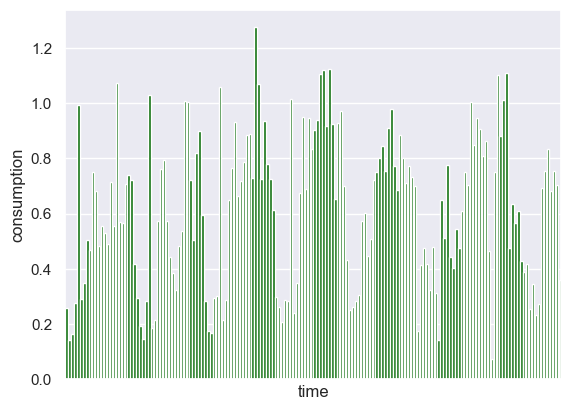

In [16]:
# Graphing the predictions

sns.set()
sns.barplot(x=test_data['time'], y=test_data['consumption'], color='green')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)  # labels along the bottom edge are off
plt.show()

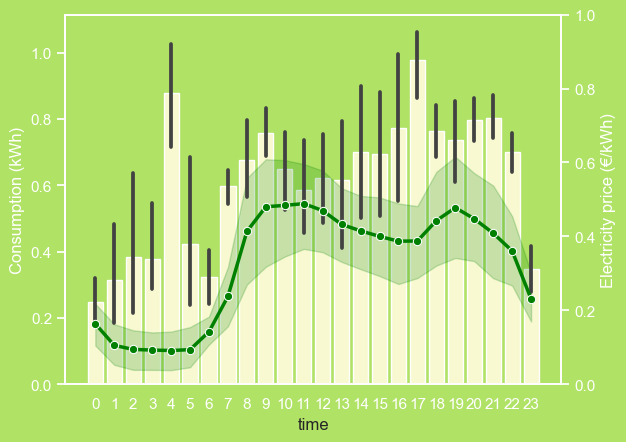

In [20]:
if create_result_graph:
    # Graphing the predictions
    sns.set(rc={'axes.facecolor': '#AFE265', 'figure.facecolor': '#AFE265'})

    days = test_data
    days = days.reset_index(drop=True)
    days['el_price'] = test_data.el_price
    days['time'] = days['time'].apply(lambda x: int(x.split(' ')[1].split(':')[0]))

    # Plot the predictions
    sns.barplot(x=days['time'], y=days['consumption'], color='#FFFFCB')
    sns.lineplot(x=days['time'], y=days['el_price'], color='green', marker='o', linewidth=2.5)
    # First y-axis
    plt.ylabel('Consumption (kWh)', color='white')
    plt.tick_params(colors='white')
    plt.grid(False)
    # Second y-axis
    ax2 = plt.twinx()
    ax2.set_ylabel('Electricity price (€/kWh)', color='white')

    # Set ax2 text color
    ax2.tick_params(axis='y', colors='white')

    ax2.grid(False)

    plt.show()
    # Show only hours
